In [2]:
from __future__ import print_function

import vdrvc 
import warnings
import numpy as np
import matplotlib.pyplot as plt

from theano import tensor as T
from sklearn.datasets import load_digits
from IPython.display import clear_output as cls
from sklearn.metrics import accuracy_score as acc
from sklearn.cross_validation import train_test_split

%matplotlib inline
warnings.simplefilter("ignore")
np.random.seed(15632)

In [3]:
data = load_digits()
X = data['images'].reshape(-1, 8*8)
t = data['target']
ww = np.mean(X, axis=0)
X -= ww
X = np.hstack((X, np.random.randn(X.shape[0], 8*8) * 5))

train = np.random.choice(1797, 1200)
test = np.setdiff1d(np.arange(1797), train)

X_train, X_test = X[train, :], X[test, :]
t_train, t_test = t[train], t[test]

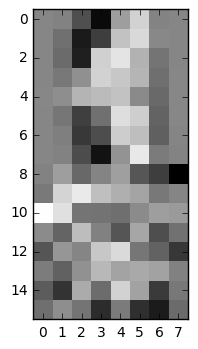

In [4]:
plt.imshow(X[11].reshape(16,8), cmap='gray', interpolation='none')

### Variational-ARD

In [5]:
vd = vdrvc.vdrvc()
vd = vd.fit(
    X_train, t_train, num_classes=10, batch_size=X_train.shape[0], 
    max_iter=200000, lr=5e-4, beta=0.98, display_each=2500)

ard = np.sum(vd.log_alpha > 5)
vd.theta[vd.log_alpha > 5] = 0
trainp, testp = acc(vd.predict(X_train), t_train), acc(vd.predict(X_test), t_test) 

print('sparsity level: %0.4f' % (ard * 1.0 / vd.theta.size))
print('train accuracy: %0.4f' % trainp)
print('test accuracy:  %0.4f' % testp)

iter = 0.0000 vlb = 200853.4716 acc = 0.0917 ard = 0.1086
iter = 2500.0000 vlb = 27870.2622 acc = 0.8475 ard = 0.0930
iter = 5000.0000 vlb = 4648.6296 acc = 0.9808 ard = 0.0992
iter = 7500.0000 vlb = 1345.6438 acc = 0.9967 ard = 0.1070
iter = 10000.0000 vlb = 390.0687 acc = 1.0000 ard = 0.1180
iter = 12500.0000 vlb = 21.2806 acc = 1.0000 ard = 0.1500
iter = 15000.0000 vlb = -73.0863 acc = 1.0000 ard = 0.1773
iter = 17500.0000 vlb = -213.1363 acc = 1.0000 ard = 0.2141
iter = 20000.0000 vlb = -270.1888 acc = 1.0000 ard = 0.2680
iter = 22500.0000 vlb = -303.3728 acc = 1.0000 ard = 0.3242
iter = 25000.0000 vlb = -322.5780 acc = 1.0000 ard = 0.3812
iter = 27500.0000 vlb = -346.2483 acc = 1.0000 ard = 0.4320
iter = 30000.0000 vlb = -416.9233 acc = 1.0000 ard = 0.4836
iter = 32500.0000 vlb = -378.7443 acc = 1.0000 ard = 0.5211
iter = 35000.0000 vlb = -443.4480 acc = 1.0000 ard = 0.5547
iter = 37500.0000 vlb = -447.7332 acc = 1.0000 ard = 0.5813
iter = 40000.0000 vlb = -398.7002 acc = 1.0000 a

(-0.5, 7.5, 15.5, -0.5)

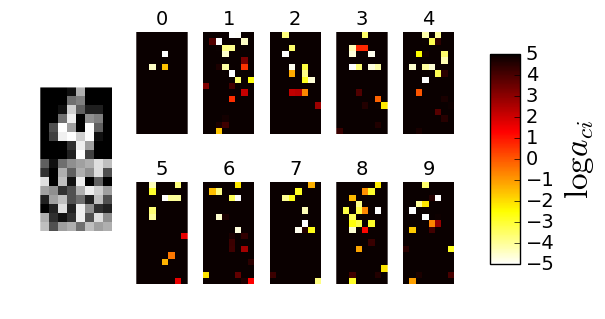

In [6]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 24,
         'axes.titlesize':14,
         'xtick.labelsize':14,
         'ytick.labelsize':14}
pylab.rcParams.update(params)

fig, ax = plt.subplots(nrows=2, ncols=5)
fig.set_size_inches(6, 3)
for i in range(10):
    im = ax[i/5, i%5].imshow(vd.log_alpha[i].reshape(16, 8).clip(-5, 5), interpolation='none', cmap='hot_r')
    ax[i/5, i%5].axis('off')
    ax[i/5, i%5].set_title(str(i))

data = load_digits()
X_ = data['images'].reshape(-1, 8*8)
t_ = data['target']
X_ = np.hstack((X_, np.random.randint(0, 16, (X_.shape[0], 8*8))))    
    

fig.tight_layout(pad=0)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cb.ax.set_ylabel(r'$\log a_{ci}$')
fig.subplots_adjust(left=0.25)
example_ax = fig.add_axes([0.1, 0.15, 0.12, 0.7])
example_ax.imshow(X_[4].reshape(16,8), cmap='gray', interpolation='none')
example_ax.axis('off')

### L1 LogisticRegression

In [7]:
from sklearn.linear_model import LogisticRegressionCV

lr = LogisticRegressionCV(penalty='l1', solver='liblinear', verbose=3, n_jobs=2).fit(X_train, t_train)

ard = np.sum(lr.coef_ == 0)
trainp, testp = acc(lr.predict(X_train), t_train), acc(lr.predict(X_test), t_test) 

print('sparsity level: %0.4f' % (ard * 1.0 / lr.coef_.size))
print('train accuracy: %0.4f' % trainp)
print('test accuracy:  %0.4f' % testp)

[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:    5.4s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]sparsity level: 0.5594
train accuracy: 0.9942
test accuracy:  0.9372


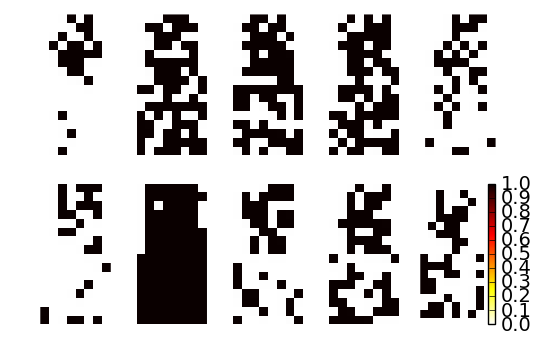

In [8]:
ax = plt.subplots(2, 5)

for i in range(10):
    im = ax[1][i/5, i%5].imshow(1-(lr.coef_[i]==0).reshape(16, 8).clip(-5, 5), interpolation='none', cmap='hot_r')
    ax[1][i/5, i%5].axis('off')

ax[0].colorbar(im)

###  Relevance Vector Classifier

In [13]:
from sklearn.metrics import accuracy_score as acc
from skbayes.rvm_ard_models.fast_rvm import ClassificationARD
# https://github.com/AmazaspShumik/sklearn-bayes

rvm = ClassificationARD().fit(X_train, t_train)

In [18]:
ard = np.array(rvm.active_).size - np.sum(rvm.active_)
trainp, testp = acc(rvm.predict(X_train), t_train), acc(rvm.predict(X_test), t_test) 
print('sparsity level: %0.4f' % (ard * 1.0 / np.array(rvm.active_).size))
print('train accuracy: %0.4f' % trainp)
print('test accuracy:  %0.4f' % testp)

sparsity level: 0.8578
train accuracy: 0.9175
test accuracy:  0.8467


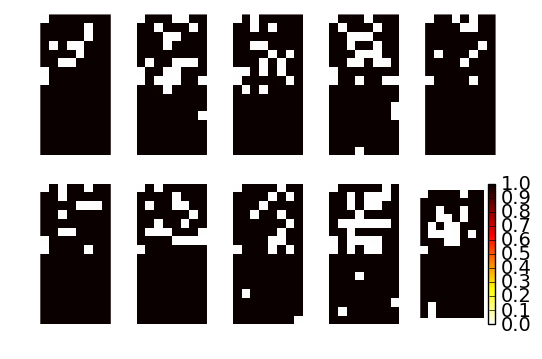

In [20]:
ax = plt.subplots(2, 5)

for i in range(10):
    im = ax[1][i/5, i%5].imshow(1-rvm.active_[i].reshape(16, 8).clip(-5, 5), interpolation='none', cmap='hot_r')
    ax[1][i/5, i%5].axis('off')

ax[0].colorbar(im)